TRPO(Trust Region Policy Optimization)

主要思想：策略梯度的改进，引入一块信任区域，这个区域的策略更新可以得到一定安全性保障，理论上可以保证策略学习的性能单调性（正常的策略梯度会因为偶尔步长太大导致策略突然显著变差（回报时不时突然大大降低）

## 策略目标

由于初始状态的分布与策略无关，那么J可以写成新策略 $\pi_{\theta '} $ 的形式：

$$\begin{aligned}J(\theta)&=\mathbb{E}_{s_0}[V^{\pi_\theta}(s_0)]\\&=\mathbb{E}_{\pi_{\theta^{\prime}}}\left[\sum_{t=0}^\infty\gamma^tV^{\pi_\theta}(s_t)-\sum_{t=1}^\infty\gamma^tV^{\pi_\theta}(s_t)\right]\\&=-\mathbb{E}_{\pi_{\theta^{\prime}}}\left[\sum_{t=0}^\infty\gamma^t\left(\gamma V^{\pi_\theta}(s_{t+1})-V^{\pi_\theta}(s_t)\right)\right]\end{aligned}$$

于是可以将新的J与原来的J作差：

$$\begin{aligned}J(\theta^{\prime})-J(\theta)&=\mathbb{E}_{s_0}\left[V^{\pi_{\theta^{\prime}}}(s_0)\right]-\mathbb{E}_{s_0}\left[V^{\pi_\theta}(s_0)\right]\\&=\mathbb{E}_{\pi_{\theta^{\prime}}}\left[\sum_{t=0}^\infty\gamma^tr(s_t,a_t)\right]+\mathbb{E}_{\pi_{\theta^{\prime}}}\left[\sum_{t=0}^\infty\gamma^t\left(\gamma V^{\pi_\theta}(s_{t+1})-V^{\pi_\theta}(s_t)\right)\right]\\&=\mathbb{E}_{\pi_{\theta^{\prime}}}\left[\sum_{t=0}^\infty\gamma^t\left[r(s_t,a_t)+\gamma V^{\pi_\theta}(s_{t+1})-V^{\pi_\theta}(s_t)\right]\right]\end{aligned}$$

定义 $ r(s_t,a_t)+\gamma V^{\pi_\theta}(s_{t+1})-V^{\pi_\theta}(s_t) $ 为 优势函数 $A$:

$$\begin{aligned}&=\mathbb{E}_{\pi_{\theta^{\prime}}}\left[\sum_{t=0}^\infty\gamma^tA^{\pi_\theta}(s_t,a_t)\right]\\&=\sum_{t=0}^\infty\gamma^t\mathbb{E}_{s_t\sim P_t^{\pi_{\theta^{\prime}}}}\mathbb{E}_{a_t\sim\pi_{\theta^{\prime}}(\cdot|s_t)}\left[A^{\pi_\theta}(s_t,a_t)\right]\\&=\frac{1}{1-\gamma}\mathbb{E}_{s\sim\nu^{\pi_{\theta^{\prime}}}}\mathbb{E}_{a\sim\pi_{\theta^{\prime}}(\cdot|s)}\left[A^{\pi_\theta}(s,a)\right]\end{aligned}$$

个人理解：优势函数的含义就是在某状态s下采取某动作a是否有Advantage,若有则为正，若无则为负，在此处可以解释的通

至于为什么一个期望可以拆成两个期望，策略 $\pi_{\theta'}$ 与s和a有关，所以依次对这两个做分布（这里把s和a服从的分布都写出来了，比较乱）

最后一个等号的成立运用到了状态访问分布的定义：

$\nu^\pi(s)=(1-\gamma)\sum_{t=0}^\infty\gamma^tP_t^\pi(s)$,所以只要我们能找到一个新策略，使得

$\mathbb{E}_{s\sim\nu^{\pi_{\theta^{\prime}}}}\mathbb{E}_{a\sim\pi_{\theta^{\prime}}(\cdot|s)}\left[A^{\pi_{\theta}}(s,a)\right]\geq0$,就能保证策略性能单调递增，即

$J(\theta^{\prime})\geq J(\theta)$。

但是直接求解该式是非常困难的，因为$\pi_{\theta^{\prime}}$是我们需要求解的策略，但我们又要用它来收集样本。把所有可能的新策略都拿来收集数据，然后判断哪个策略满足上述条件的做法显然是不现实的。于是 TRPO 做了一步近似操作，对状态访问分布进行了相应处理。具体而言，忽略两个策略之间的状态访问分布变化，直接采用旧的策略$\pi_{\theta}$的状态分布，定义如下替代优化目标：

$$L_\theta(\theta')=J(\theta)+\frac1{1-\gamma}\mathbb{E}_{s\sim\nu^{\pi_\theta}}\mathbb{E}_{a\sim\pi_{\theta^{\prime}}(\cdot|s)}\left[A^{\pi_\theta}(s,a)\right]$$

当新旧策略非常接近时，状态访问分布变化很小，这么近似是合理的。其中，动作仍然用新策略$\pi_\mathrm{\theta^{\prime}}$采样得到，我们可以用重要性采样对动作分布进行处理：

$$L_\theta(\theta')=J(\theta)+\mathbb{E}_{s\sim\nu^{\pi_\theta}}\mathbb{E}_{a\sim\pi_\theta(\cdot|s)}\left[\frac{\pi_{\theta'}(a|s)}{\pi_\theta(a|s)}A^{\pi_\theta}(s,a)\right]$$

这样，我们就可以基于旧策略$\pi_\theta$已经采样出的数据来估计并优化新策略$\pi_\theta$ 了。为了保证新旧策略足够接近，TRPO 使用了库尔贝克·莱布勒 (KullbackLeibler,KL)散度来衡量策略之间的距离，并给出了整体的优化公式：

$$\begin{aligned}&\max_{\theta^{\prime}}L_\theta(\theta^{\prime})\\&\mathrm{s.t.~}\mathbb{E}_{s\sim\nu^{\pi_{\theta_k}}}[D_{KL}(\pi_{\theta_k}(\cdot|s),\pi_{\theta^{\prime}}(\cdot|s))]\leq\delta\end{aligned}$$

这里的不等式约束定义了策略空间中的一个KL 球，被称为信任区域。在这个区域中，可以认为当前学习策略和环境交互的状态分布与上一轮策略最后采样的状态分布一致，进而可以基于一步行动的重要性采样方法使当前学习策略稳定提升

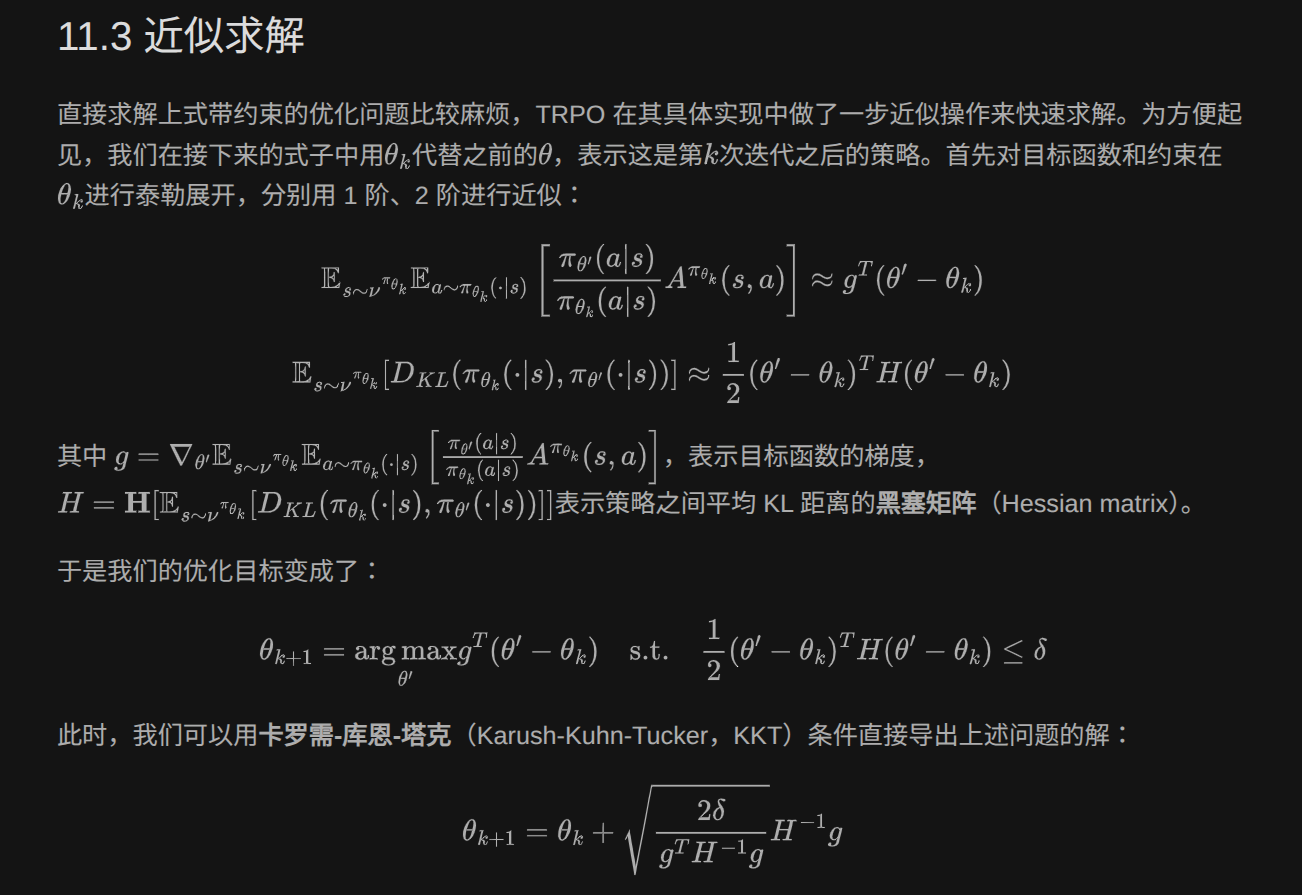

[此处近似的理解](https://blog.csdn.net/wxc971231/article/details/135591016)

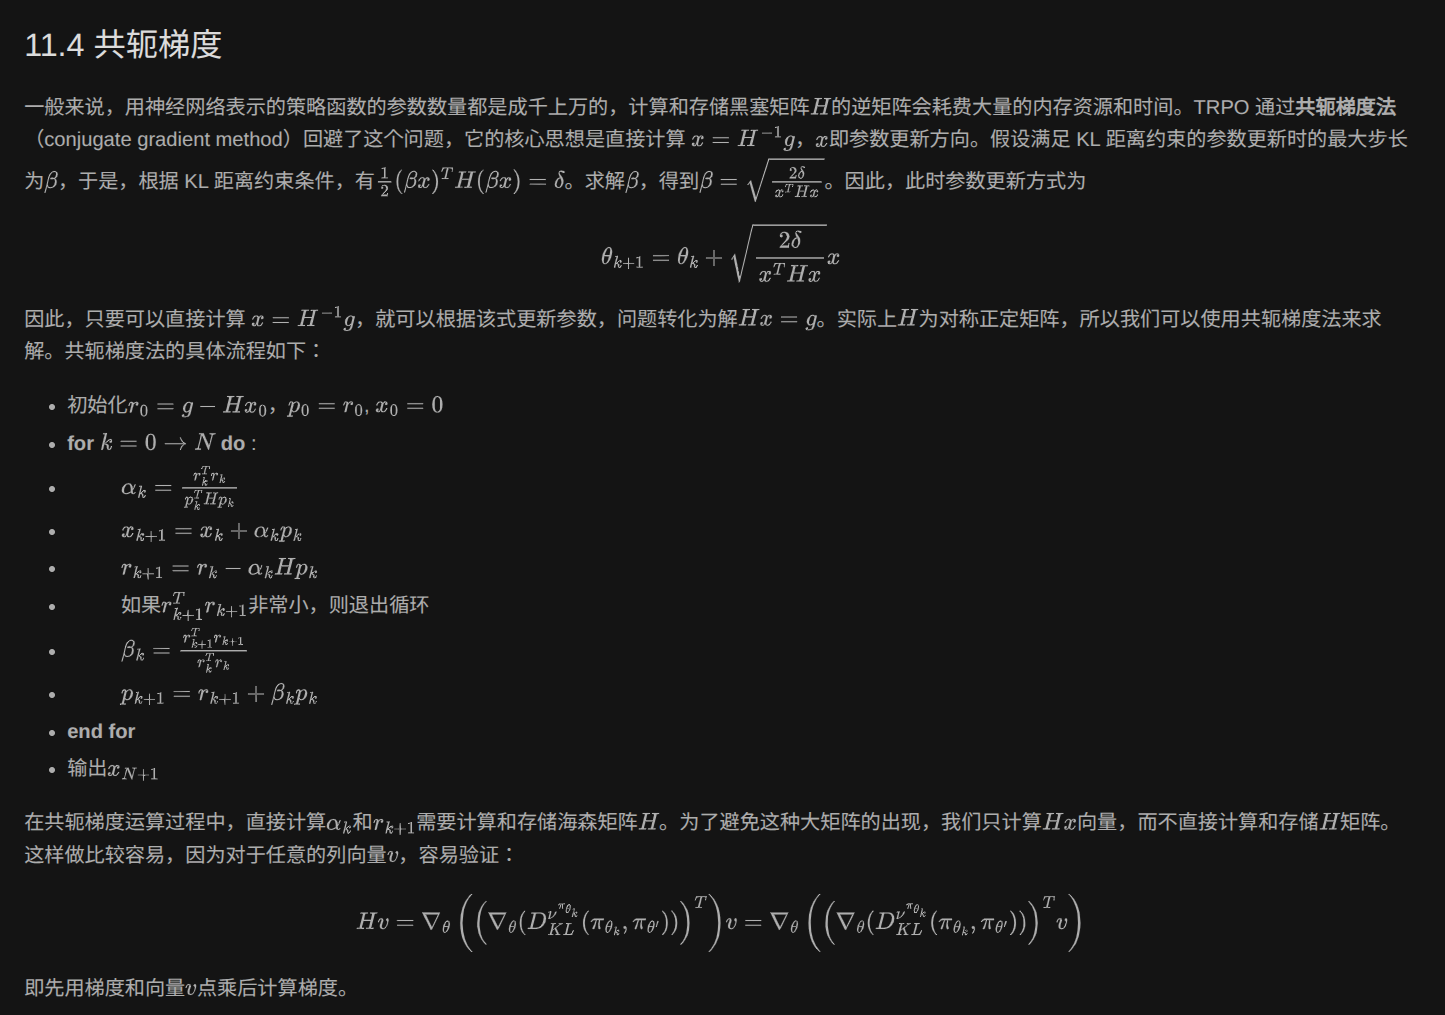

[共轭梯度的理解](https://zhuanlan.zhihu.com/p/338838078)

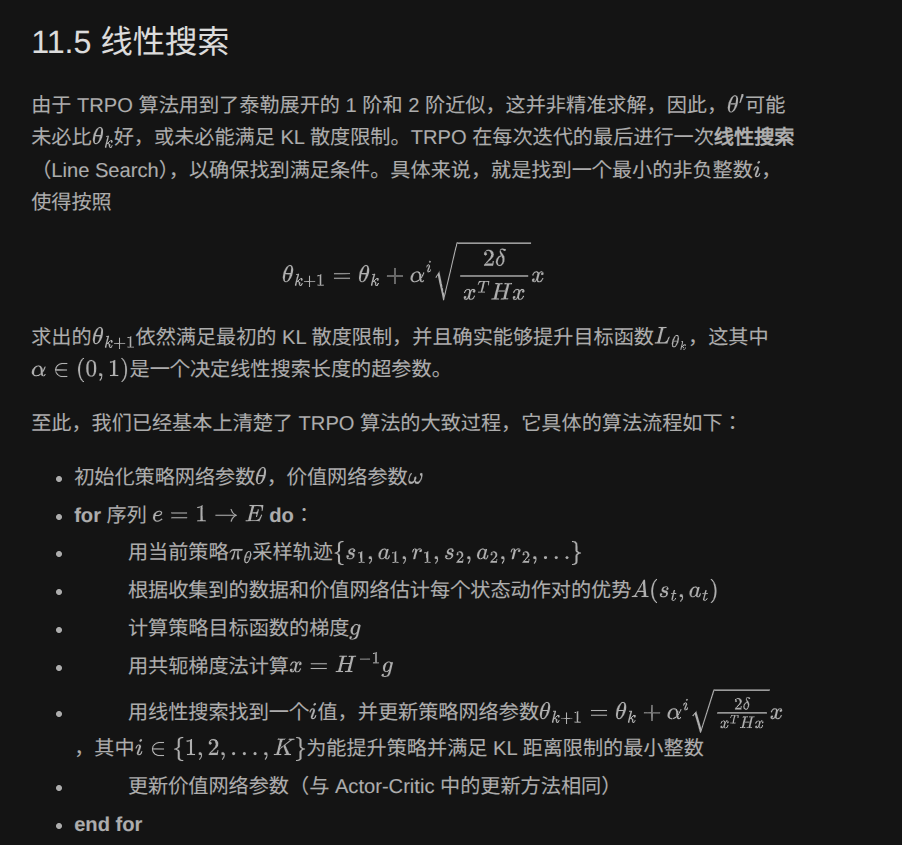

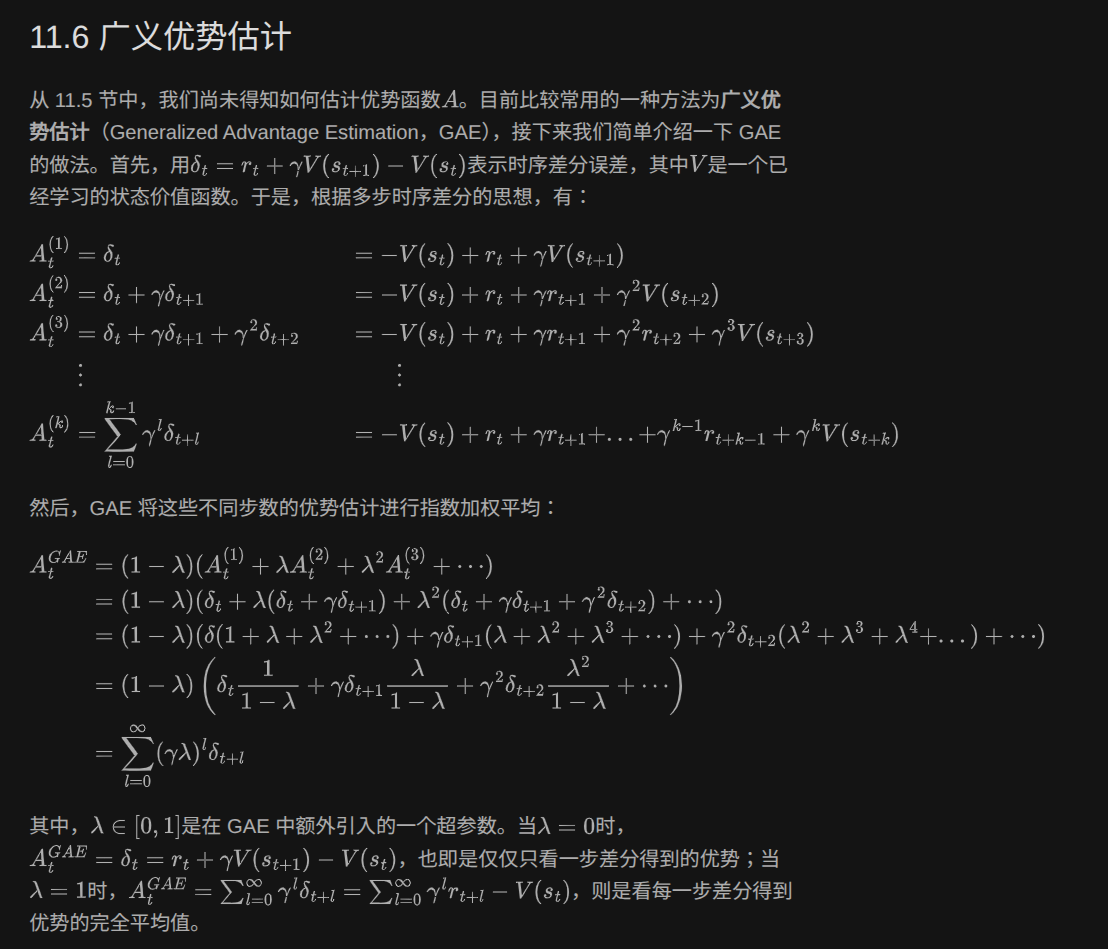

In [3]:
"""TRPO实现"""

import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
import rl_utils
import copy
from tqdm import tqdm

"""这里同AC"""
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def compute_advantage(gamma, lmbda, td_delta):  # 估计优势函数
        td_delta = td_delta.detach().numpy()
        advantage_list = []
        advantage = 0.0
        for delta in td_delta[::-1]:
            advantage = gamma * lmbda * advantage + delta
            advantage_list.append(advantage)
        advantage_list.reverse()
        return torch.tensor(advantage_list, dtype=torch.float)

class TRPO:
    """ TRPO算法 """
    def __init__(self, hidden_dim, state_space, action_space, lmbda,
                 kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_space.shape[0]
        action_dim = action_space.n
        # 策略网络参数不需要优化器更新
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda  # GAE参数
        self.kl_constraint = kl_constraint  # KL距离最大限制
        self.alpha = alpha  # 线性搜索参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    
    def hessian_matrix_vector_product(self, states, old_action_dists, vector):
        # 计算黑塞矩阵和一个向量的乘积,节省空间
        new_action_dists = torch.distributions.Categorical(self.actor(states))
        kl = torch.mean(
            torch.distributions.kl.kl_divergence(old_action_dists,
                                                 new_action_dists))  # 计算平均KL距离
        kl_grad = torch.autograd.grad(kl,
                                      self.actor.parameters(),
                                      create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        # KL距离的梯度先和向量进行点积运算
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product,
                                    self.actor.parameters())
        grad2_vector = torch.cat([grad.view(-1) for grad in grad2])

        return grad2_vector
    
    def conjugate_gradient(self, grad, states, old_action_dists):
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)

        for i in range(10):
            Hp = self.hessian_matrix_vector_product(states, old_action_dists, p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x

    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                              actor):  # 计算策略目标L
        log_probs = torch.log(actor(states).gather(1, actions))
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, states, actions, advantage, old_log_probs,
                    old_action_dists, max_vec):  # 线性搜索
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(
            self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage,
                                             old_log_probs, self.actor)
        for i in range(15):  # 线性搜索主循环
            coef = self.alpha ** i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            torch.nn.utils.convert_parameters.vector_to_parameters(
                new_para, new_actor.parameters())
            new_action_dists = torch.distributions.Categorical(
                new_actor(states))
            kl_div = torch.mean(
                torch.distributions.kl.kl_divergence(old_action_dists,
                                                     new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                 old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para
    
    def policy_learn(self, states, actions, old_action_dists, old_log_probs, 
                     advantage): # 更新策略函数
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                   old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()

        # 用共轭梯度法计算x = H^(-1)g
        descent_direction = self.conjugate_gradient(obj_grad, states,
                                                    old_action_dists)

        Hd = self.hessian_matrix_vector_product(states, old_action_dists,
                                                descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint /
                              (torch.dot(descent_direction, Hd) + 1e-8))
        new_para = self.line_search(states, actions, advantage, old_log_probs,
                                    old_action_dists,
                                    descent_direction * max_coef)  # 线性搜索
        torch.nn.utils.convert_parameters.vector_to_parameters(
            new_para, self.actor.parameters())  # 用线性搜索后的参数更新策略
        
        
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        
        # 时序差分的目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)

        #时序差分的误差
        td_delta = td_target - self.critic(states)

        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)   # numpy不兼容gpu,要先把td_delta搬到cpu

        old_log_probs = torch.log(self.actor(states).gather(1,actions)).detach()
        old_action_dists = torch.distributions.Categorical(
            self.actor(states).detach())
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()  # 更新价值函数
        # 更新策略函数
        self.policy_learn(states, actions, old_action_dists, old_log_probs, advantage)



Iteration 9: 100%|██████████| 100/100 [00:07<00:00, 13.03it/s, episode=1000, return=200.000]


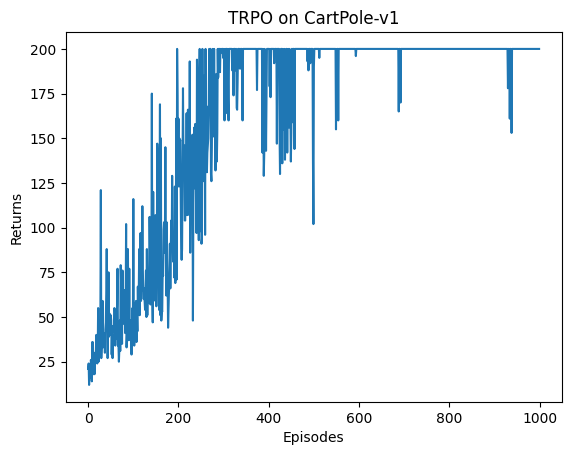

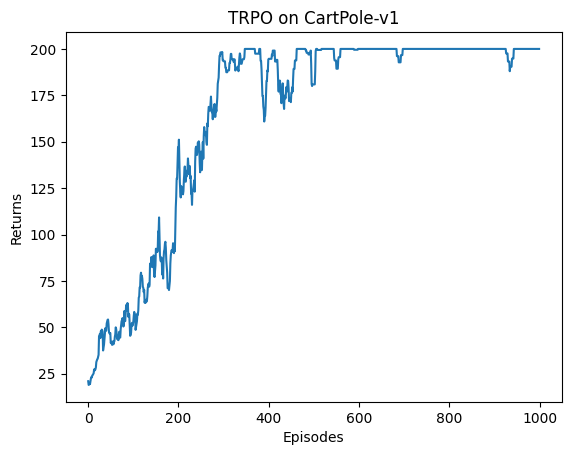

In [4]:
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
critic_lr = 1e-2
kl_constraint = 0.0005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
agent = TRPO(hidden_dim, env.observation_space, env.action_space, lmbda,
             kl_constraint, alpha, critic_lr, gamma, device)
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

In [5]:
"""处理倒立摆环境"""

import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
import rl_utils
import copy
from tqdm import tqdm

class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std  # 高斯分布的均值和标准差

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def compute_advantage(gamma, lmbda, td_delta):  # 估计优势函数
        td_delta = td_delta.detach().numpy()
        advantage_list = []
        advantage = 0.0
        for delta in td_delta[::-1]:
            advantage = gamma * lmbda * advantage + delta
            advantage_list.append(advantage)
        advantage_list.reverse()
        return torch.tensor(advantage_list, dtype=torch.float)

class TRPOContinuous:
    """ 处理连续动作的TRPO算法 """
    def __init__(self, hidden_dim, state_space, action_space, lmbda,
                 kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_space.shape[0]
        action_dim = action_space.shape[0]
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.kl_constraint = kl_constraint
        self.alpha = alpha
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, std = self.actor(state)
        action_dist = torch.distributions.Normal(mu, std)
        action = action_dist.sample()
        return [action.item()]

    def hessian_matrix_vector_product(self,
                                      states,
                                      old_action_dists,
                                      vector,
                                      damping=0.1):
        mu, std = self.actor(states)
        new_action_dists = torch.distributions.Normal(mu, std)
        kl = torch.mean(
            torch.distributions.kl.kl_divergence(old_action_dists,
                                                 new_action_dists))
        kl_grad = torch.autograd.grad(kl,
                                      self.actor.parameters(),
                                      create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product,
                                    self.actor.parameters())
        grad2_vector = torch.cat(
            [grad.contiguous().view(-1) for grad in grad2])
        return grad2_vector + damping * vector

    def conjugate_gradient(self, grad, states, old_action_dists):
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):
            Hp = self.hessian_matrix_vector_product(states, old_action_dists,
                                                    p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x

    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                              actor):
        mu, std = actor(states)
        action_dists = torch.distributions.Normal(mu, std)
        log_probs = action_dists.log_prob(actions)
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, states, actions, advantage, old_log_probs,
                    old_action_dists, max_vec):
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(
            self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage,
                                             old_log_probs, self.actor)
        for i in range(15):
            coef = self.alpha**i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            torch.nn.utils.convert_parameters.vector_to_parameters(
                new_para, new_actor.parameters())
            mu, std = new_actor(states)
            new_action_dists = torch.distributions.Normal(mu, std)
            kl_div = torch.mean(
                torch.distributions.kl.kl_divergence(old_action_dists,
                                                     new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                 old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para

    def policy_learn(self, states, actions, old_action_dists, old_log_probs,
                     advantage):
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                   old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        descent_direction = self.conjugate_gradient(obj_grad, states,
                                                    old_action_dists)
        Hd = self.hessian_matrix_vector_product(states, old_action_dists,
                                                descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint /
                              (torch.dot(descent_direction, Hd) + 1e-8))
        new_para = self.line_search(states, actions, advantage, old_log_probs,
                                    old_action_dists,
                                    descent_direction * max_coef)
        torch.nn.utils.convert_parameters.vector_to_parameters(
            new_para, self.actor.parameters())

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 对奖励进行修改,方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda,
                                      td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        old_action_dists = torch.distributions.Normal(mu.detach(),
                                                      std.detach())
        old_log_probs = old_action_dists.log_prob(actions)
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        self.policy_learn(states, actions, old_action_dists, old_log_probs,
                          advantage)

Iteration 9: 100%|██████████| 200/200 [00:17<00:00, 11.32it/s, episode=2000, return=-987.167]


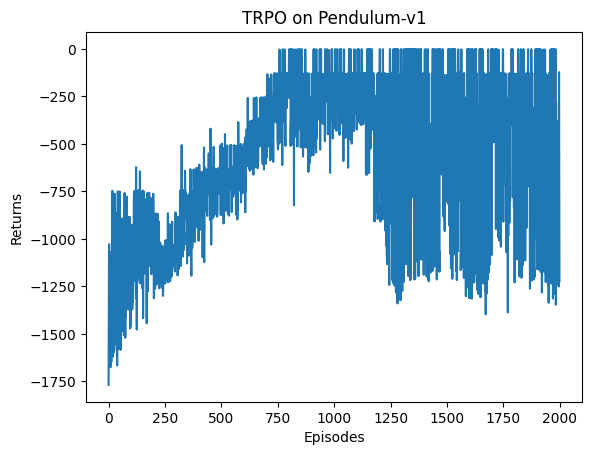

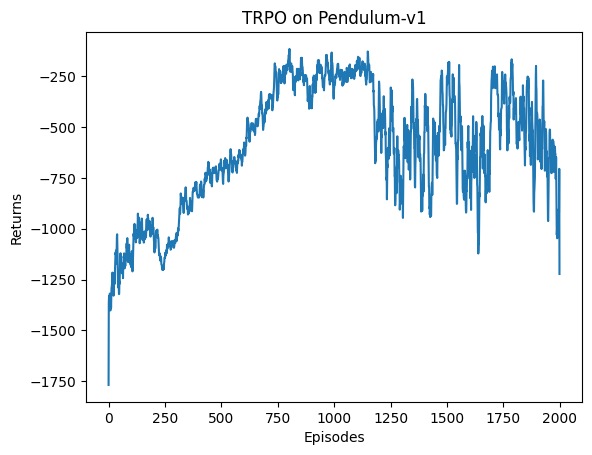

In [6]:
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
critic_lr = 1e-2
kl_constraint = 0.0005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
agent = TRPOContinuous(hidden_dim, env.observation_space, env.action_space, lmbda,
             kl_constraint, alpha, critic_lr, gamma, device)
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()